In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py


SRP_name = 'aggregates'
resolution = '1kbp_raw' 
species= 'human'


def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()


exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'
jac_sim_spr = hm.hiCMatrix(exp_file_path)
all_genes_spr = [x[3].decode() for x in jac_sim_spr.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim_spr.matrix.toarray() ,  index=all_genes_spr, columns = all_genes_spr)
  

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
  
chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
chrom_index_list = {}
for chrom in chr_list:
      st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
      en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
      chrom_index_list[chrom] = list(range(st, en+1))
gene_bed = pd.read_csv(f'{input_path}/all_gene.bed', names=['chr', 'start_bin', 'end_bin', 'gene'])


all_markers_df = []
for marker_type in ['class', 'subclass', 'type']:
	marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/type_markers_top1000.csv.gz', skiprows=1)
	all_markers_df.append(marker_list)

marker_list = pd.concat(all_markers_df)
marker_list = marker_list.drop_duplicates(subset=['gene'])
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
marker_list = marker_list.drop_duplicates(subset=['Ensembl_gene_identifier'])




with h5py.File(f'{input_path}/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
        tot_g = (list(hf.keys()))

all_background_markers = list(set(all_genes_spr) -  set(marker_list['Ensembl_gene_identifier'].tolist())) + marker_list['Ensembl_gene_identifier'].tolist()



marker_contacts_list_inter = []

gene_list = []
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
                   
                   for key in all_background_markers:
                    if key in tot_g:
                            
                            gene_list.append(key)
                            gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                            #which ever chrom the gene falls into, those bins should be nan
                            my_data = hf[key][()]
                            my_data = my_data.astype('float32')
                            #my_data[chrom_index_list[gene_chrom]] = np.nan
                            marker_contacts_list_inter.append(my_data)

my_data = np.array(marker_contacts_list_inter)


INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [92]:
stats.rankdata([0,3, np.nan,6])

array([1., 2., 4., 3.])

In [2]:
df_max_gene_inter_by_bins = pd.DataFrame(my_data, index=gene_list, columns = bins_bed['bin_id'].tolist())

df_max_gene_inter_by_bins_sum = df_max_gene_inter_by_bins.sum().reset_index()

df_max_gene_inter_by_bins_sum_mean = df_max_gene_inter_by_bins.mean().reset_index()

In [3]:
import os
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:

        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(all_genes_spr)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []


        for group, cell_type in zip(marker_list_groups, marker_list_types):
            
            
            marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

            df_tmp = df_max_gene_inter_by_bins.loc[marker_genes_group, :].mean(skipna=True).reset_index()

            df_tmp= df_tmp.set_index('index')
            df_tmp.rename(columns = {0:'mean_cell_type'}, inplace = True)

            d2 = df_tmp[['mean_cell_type']].T
            cell_type_list_order.append(cell_type)
            #d2['cell_type'] = cell_type
            #d2['subclass'] = group
            #d2['class'] = class_dict[group]
            
            df_list_mean.append(d2)
            #print (cell_type)
            
        df_concat_list_mean_nn = pd.concat(df_list_mean)
        column_list = df_concat_list_mean_nn.columns.tolist()
        print (number_of_genes)

        from umap import UMAP
        import plotly.express as px

        df = df_concat_list_mean_nn.dropna(axis=1)


        features = df

        umap_2d = UMAP(n_components=2, init='random', random_state=0)


        proj_2d = umap_2d.fit_transform(features)


        j = df_concat_list_mean_nn.to_numpy()
        
        

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        
        with h5py.File(outfile_name, 'a') as hf:
                            


            hf.create_dataset('type_contacts',data=j)
            hf.create_dataset('type_list',data=cell_type_list_order)
            hf.create_dataset('column_list',data=column_list)
            

            

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_proj_2d_gw.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        with h5py.File(outfile_name, 'a') as hf:
                            

            hf.create_dataset('proj_2d',data=proj_2d)
            hf.create_dataset('type_list',data=cell_type_list_order)
            

10


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


10


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


10
50


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


50


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


50
100


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


100


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


100
150


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


150


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


150
200


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


200


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


200
250


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


250


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


250
500


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


500


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


500
1000


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


KeyboardInterrupt: 

In [22]:
df_max_gene_inter_by_bins_max = df_max_gene_inter_by_bins.max(skipna=True).reset_index()

df_max_gene_inter_by_bins_min = df_max_gene_inter_by_bins.min(skipna=True).reset_index()

df_max_gene_inter_by_bins_std = df_max_gene_inter_by_bins.std(skipna=True).reset_index()

In [210]:
marker_level='type'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_proj_2d_gw.h5', 'r') as hf:
                   
        proj_2d = hf['proj_2d'][()]
        type_list = hf['type_list'][()]
        

In [212]:
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    subclass_list = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    class_list = [class_dict[x] for x in subclass_list]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.



<AxesSubplot:>

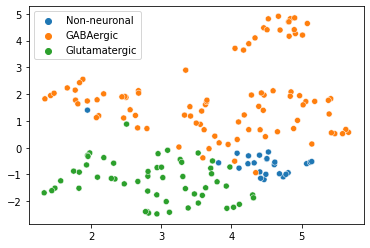

In [214]:
%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=class_list)

In [215]:
df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['start']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
#df_cre_1kb = df_cre.drop_duplicates(subset=['start_bin'])

df_cre_1kb_start = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['end']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
df_cre_1kb_end = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')


df_cre_1kb = pd.concat([df_cre_1kb_start, df_cre_1kb_end])

In [216]:
cre_bins = list( set(df_cre_1kb.bin_id.tolist()))

In [272]:

marker_level='subclass'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())
#df_max_gene_inter_by_bins['group'] = [x.decode() for x in type_list.tolist()]

#df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)


In [218]:
df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_max[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_std[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized = (df_max_gene_inter_by_bins_sum_mean[0]-df_max_gene_inter_by_bins_tmp).div(df_max_gene_inter_by_bins_std[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_1 = (df_max_gene_inter_by_bins_tmp-df_max_gene_inter_by_bins_sum_mean[0]).div(df_max_gene_inter_by_bins_std[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_2 = (df_max_gene_inter_by_bins_tmp-df_max_gene_inter_by_bins_sum_mean[0]).div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized = df_concat_list_mean_nn_by_bins_normalized_1.mul(df_max_gene_inter_by_bins_sum_mean[0], axis=1)



In [219]:
from umap import UMAP
import plotly.express as px

df = df_concat_list_mean_nn_by_bins_normalized.dropna(axis=1)


features = df
#features = df.loc[:, nongene_bins_all_present]




umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

<AxesSubplot:>

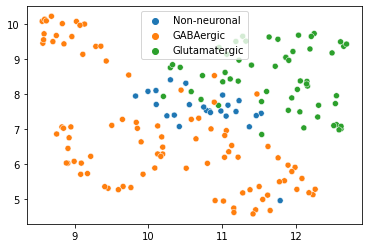

In [220]:
%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=class_list)

In [221]:
df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

df_cre['start_bin'] = df_cre['start']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
#df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

In [229]:
df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['start']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
#df_cre_1kb = df_cre.drop_duplicates(subset=['start_bin'])

df_cre_1kb_start = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['end']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
df_cre_1kb_end = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')


df_cre_1kb = pd.concat([df_cre_1kb_start, df_cre_1kb_end])


In [262]:
high_mean = df_max_gene_inter_by_bins_sum_mean[0][df_max_gene_inter_by_bins_sum_mean[0] >0.8].index.tolist()


In [263]:
cre_bins = list(set(high_mean).intersection(set(df_cre_1kb.bin_id.tolist())))

In [246]:
cre_bins = list( set(df_cre_1kb.bin_id.tolist()))



In [266]:
gene_bins_all = pd.read_csv(f'{input_path}/gene_bins_list.csv')['0'].tolist()

all_bins_present = bins_bed['bin_id'].tolist()

gene_bins_all_present = list(set(gene_bins_all).intersection(set(all_bins_present)))

nongene_bins_all_present = list(set(all_bins_present) - set(gene_bins_all))

cre_bins = list(set(nongene_bins_all_present).intersection(set(df_cre_1kb.bin_id.tolist())))

<AxesSubplot:>

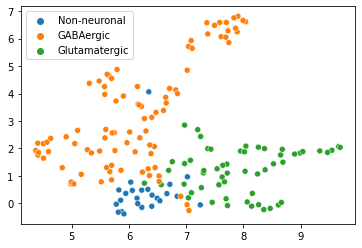

In [270]:
from umap import UMAP
import plotly.express as px

df = df_max_gene_inter_by_bins_tmp.loc[:, cre_bins].dropna(axis=1)


#features = df
features = df




umap_2d = UMAP(n_components=2, init='random', random_state=0)




proj_2d = umap_2d.fit_transform(features)


%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=class_list)

In [268]:
from umap import UMAP
import plotly.express as px
import seaborn as sns




fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=subclass_list, labels={'color': 'group'}, color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta", "tomato", "black", "lime", "cyan", "teal", "aqua", "lime", "chocolate", "violet", "black", "lightcoral", "yellowgreen", "orchid", "grey"]
)


fig_2d.show()

In [273]:
df2 = df_max_gene_inter_by_bins_sum_mean.merge(df_max_gene_inter_by_bins_tmp.T, right_on=df_max_gene_inter_by_bins_tmp.T.index, left_on='index')


In [290]:
df_exp_tp['group']

tp          l2/3 it
tp            l4 it
tp            l5 it
tp            l6 it
tp       l6 it car3
tp            l6 ct
tp              l6b
tp          l5/6 np
tp            l5 et
tp        sst chodl
tp              sst
tp            pvalb
tp       chandelier
tp              vip
tp             sncg
tp            lamp5
tp       lamp5_lhx6
tp            astro
tp        micro-pvm
tp              opc
tp            oligo
tp             endo
tp    glutamatergic
tp        gabaergic
tp     non-neuronal
Name: group, dtype: object

In [306]:
df_exp_tp_zcore = df_exp_tp.loc[:,df_exp_tp.columns!='group'].apply(stats.zscore)

df_exp_tp_zcore['group'] = df_exp_tp['group'].tolist()

In [335]:
df3 = df2.merge(df_exp_tp_zcore.iloc[22].reset_index(), left_on='index', right_on='bin_id')

In [336]:
df3['contact_by_mean'] = [np.nan if y == 0 else x/y for x,y in zip(df3['L6b'],df3[0]) ]

In [280]:
df3

index         0  Chandelier  Lamp5  Lamp5_Lhx6   Pax6  Pvalb   Sncg  \
0             9  0.000000       0.000  0.000       0.000  0.000  0.000  0.000   
1           180  0.061198       0.190  0.160       0.185  0.170  0.195  0.180   
2           191  0.824590       1.105  1.125       1.150  1.160  1.170  1.200   
3           267  0.410228       0.975  0.925       0.890  0.970  0.860  0.980   
4           585  0.015896       0.050  0.035       0.040  0.035  0.040  0.035   
...         ...       ...         ...    ...         ...    ...    ...    ...   
487820  2874850  0.879437       1.195  1.050       1.095  1.040  1.095  1.225   
487821  2874855  0.738760       1.055  1.010       1.035  1.020  1.075  1.115   
487822  2874976  0.757170       0.990  0.910       0.980  0.880  1.005  1.055   
487823  2874978  0.594375       0.880  0.805       0.730  0.840  0.870  0.930   
487824  2875000  0.179288       0.485  0.460       0.520  0.425  0.435  0.485   

          Sst  Sst Chodl  ...       L6b  Astro   Endo  Micro-PVM  Oligo  \
0       0.000      0.000  ...  0.000000  0.000  0.000      0.000  0.000   
1       0.175      0.220  ...  0.165829  0.115  0.135      0.170  0.120   
2       1.285      1.185  ...  1.070352  1.010  1.075      1.120  1.060   
3       0.895      0.880  ...  0.773869  0.650  0.690      0.715  0.800   
4       0.035      0.015  ...  0.030151  0.035  0.040      0.040  0.015   
...       ...        ...  ...       ...    ...    ...        ...    ...   
487820  1.110      1.095  ...  0.979900  1.435  1.045      1.190  1.080   
487821  1.095      1.055  ...  1.015075  1.150  0.990      1.140  1.005   
487822  0.970      1.145  ...  0.874372  0.905  0.915      0.955  0.900   
487823  0.915      0.875  ...  0.798995  0.905  0.815      0.820  0.785   
487824  0.520      0.490  ...  0.346734  0.345  0.325      0.410  0.340   

          OPC   VLMC   bin_id        tp  contact_by_mean  
0       0.000  0.000        9  0.428571              NaN  
1       0.215  0.140      180       0.5         2.709736  
2       1.255  1.850      191  0.428571         1.298041  
3       1.025  0.855      267  0.285714         1.886437  
4       0.035  0.010      585  0.214286         1.896749  
...       ...    ...      ...       ...              ...  
487820  1.225  1.155  2874850  0.285714         1.114234  
487821  1.145  1.095  2874855  0.285714         1.374026  
487822  1.110  1.055  2874976       0.5         1.154789  
487823  0.980  0.885  2874978  0.214286         1.344262  
487824  0.510  0.400  2875000  0.285714         1.933945  

[487825 rows x 29 columns]

<AxesSubplot:>

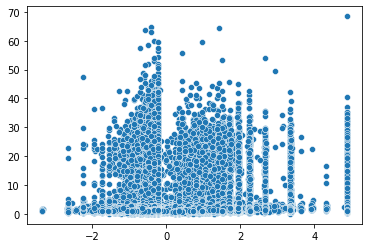

In [330]:
sns.scatterplot(y=df3['contact_by_mean'].tolist(), x=df3['tp'].tolist())

<AxesSubplot:>

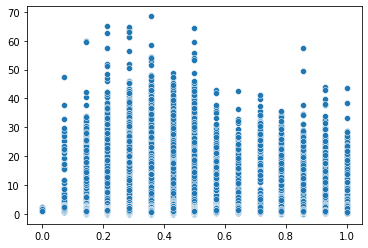

In [333]:
sns.scatterplot(y=df3['contact_by_mean'].tolist(), x=df3['tp'].tolist())

In [340]:
df3[df3[0]>0.5]

index         0  Chandelier  Lamp5  Lamp5_Lhx6   Pax6  Pvalb   Sncg  \
2           191  0.824590       1.105  1.125       1.150  1.160  1.170  1.200   
5           629  0.605242       1.170  1.300       1.105  1.290  1.260  1.220   
6           633  0.981078       1.550  1.350       1.310  1.400  1.595  1.545   
7           778  1.047901       1.165  1.060       1.095  0.995  1.045  1.120   
8           779  0.941019       1.030  1.015       1.035  0.945  1.070  1.080   
...         ...       ...         ...    ...         ...    ...    ...    ...   
487819  2874836  1.626465       1.830  1.780       1.810  1.805  1.870  1.935   
487820  2874850  0.879437       1.195  1.050       1.095  1.040  1.095  1.225   
487821  2874855  0.738760       1.055  1.010       1.035  1.020  1.075  1.115   
487822  2874976  0.757170       0.990  0.910       0.980  0.880  1.005  1.055   
487823  2874978  0.594375       0.880  0.805       0.730  0.840  0.870  0.930   

          Sst  Sst Chodl  ...       L6b  Astro   Endo  Micro-PVM  Oligo  \
2       1.285      1.185  ...  1.070352  1.010  1.075      1.120  1.060   
5       1.440      1.205  ...  1.075377  0.955  1.160      0.905  1.275   
6       1.765      1.655  ...  1.160804  1.275  1.300      1.490  1.190   
7       1.130      1.050  ...  0.919598  1.000  0.970      1.100  0.985   
8       1.030      1.015  ...  1.015075  0.985  0.970      1.045  1.020   
...       ...        ...  ...       ...    ...    ...        ...    ...   
487819  1.830      1.800  ...  1.698492  2.325  1.630      1.955  1.710   
487820  1.110      1.095  ...  0.979900  1.435  1.045      1.190  1.080   
487821  1.095      1.055  ...  1.015075  1.150  0.990      1.140  1.005   
487822  0.970      1.145  ...  0.874372  0.905  0.915      0.955  0.900   
487823  0.915      0.875  ...  0.798995  0.905  0.815      0.820  0.785   

          OPC   VLMC   bin_id        tp  contact_by_mean  
2       1.255  1.850      191 -1.012717         1.298041  
5       1.490  1.245      629 -0.420201         1.776772  
6       1.710  1.350      633       NaN         1.183192  
7       1.195  1.265      778  0.086411         0.877562  
8       1.135  1.255      779  0.722315         1.078699  
...       ...    ...      ...       ...              ...  
487819  2.150  1.790  2874836  0.489898         1.044285  
487820  1.225  1.155  2874850       NaN         1.114234  
487821  1.145  1.095  2874855  0.489898         1.374026  
487822  1.110  1.055  2874976  -0.07387         1.154789  
487823  0.980  0.885  2874978 -0.236508         1.344262  

[287796 rows x 29 columns]

<AxesSubplot:>

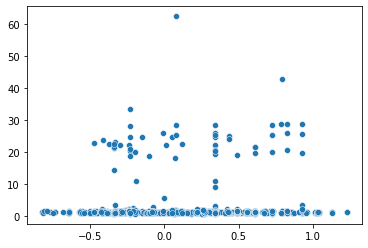

In [350]:
sns.scatterplot(y=df3[df3['L6b']>20]['Vip'].tolist(), x=df3[df3['L6b']>20]['tp'].tolist())

<AxesSubplot:>

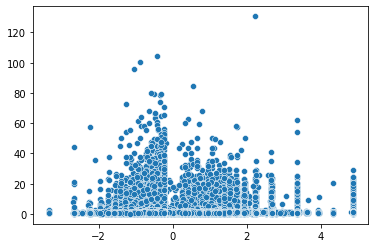

In [329]:
sns.scatterplot(y=df3['Vip'].tolist(), x=df3['tp'].tolist())

<AxesSubplot:>

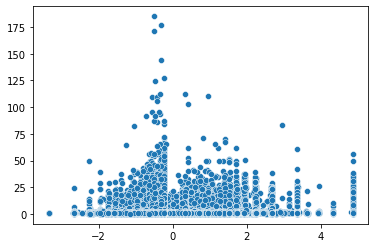

In [313]:
sns.scatterplot(y=df3['L6b'].tolist(), x=df3['tp'].tolist())

<AxesSubplot:>

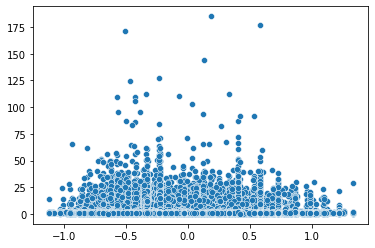

In [308]:
sns.scatterplot(y=df3['L6b'].tolist(), x=df3['tp'].tolist())

<AxesSubplot:>

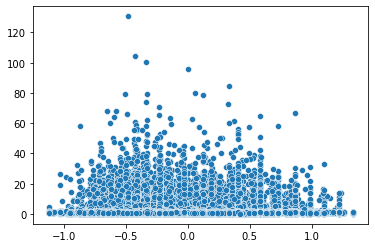

In [309]:
sns.scatterplot(y=df3['Vip'].tolist(), x=df3['tp'].tolist())

In [373]:
marker_level='class'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())
#df_concat_list_mean_nn_by_bins_normalized_tmp = [np.nan if ]
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_sum_mean[0]

#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(((df_max_gene_inter_by_bins_sum_mean[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.dropna(axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.mul(((df_max_gene_inter_by_bins_sum_mean[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(((1-df_max_gene_inter_by_bins_sum[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_max_gene_inter_by_bins_tmp - df_max_gene_inter_by_bins_sum_mean[0]).div(df_max_gene_inter_by_bins_std[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_concat_list_mean_nn_by_bins_normalized_tmp).div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_max_gene_inter_by_bins_tmp*0)+df_max_gene_inter_by_bins_std[0]
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(df_concat_list_mean_nn_by_bins_normalized_max, axis=1)

#df_concat_list_mean_nn_by_bins_normalized_tmp =  ( (df_max_gene_gw_by_bins_sum['0']/2875012)+1-df_concat_list_mean_nn_by_bins_normalized_tmp)
#df_concat_list_mean_nn_by_bins_normalized_tmp =   1-df_concat_list_mean_nn_by_bins_normalized_tmp
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.abs()
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp * df_max_gene_inter_by_bins_sum_mean[0]
#df_max_gene_inter_by_bins_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp
#df_max_gene_inter_by_bins_tmp = df_max_gene_inter_by_bins_tmp.loc[:,var_index ]


df_max_gene_inter_by_bins_tmp['group'] = [x.decode() for x in type_list.tolist()]



if marker_level != 'type':

    df_group_max = df_max_gene_inter_by_bins_tmp

    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list4 = []
    tp_list4 = []
    for group_t in intersection_bin[:100]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list4.append(calc_auroc(df, 'enrich'))
                tp_list4.append(df['true_pos'].tolist())

                #print (calc_auroc(df, 'enrich'))
                print (marker_level, np.nanmean(np.array(val_list4)))
    print (marker_level, np.nanmean(np.array(val_list4)))
    
    df_exp_tp_intersection_min = df_exp_tp_intersection.min(axis=1).reset_index()[0].tolist()
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        #j = [x-base for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]
        #df['true_pos'] = [1 if (x-base)>0 else 0 for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]
        df['true_pos'] = [1 if (x>0) else 0 for x in df['true_pos'] ]
        #max_value = np.percentile(df['true_pos'].tolist(), 90)
        #print (max_value)
        
        #df_z = abs(stats.zscore(df['true_pos'].tolist()))
        #max_value =np.percentile(df_z, 90)
        #df['true_pos'] = [1 if x<=max_value else 0 for x in df_z ]
        
        #print ([x-base for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ])
        #print (max([x-base for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]))
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        
        print (df['true_neg'].sum())
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
                

if marker_level == 'subclass':
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    print (class_dict)
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/class_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    bins_int = []
    for group_t in intersection_bin[0:10000]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            #max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                bins_int.append(group_t)

                #print (calc_auroc(df, 'enrich'))
                print (marker_level, "subclass", np.nanmean(np.array(val_list3)))
    print (marker_level, "subclass", np.nanmean(np.array(val_list3)))
    
    df_exp_tp_intersection_min = df_exp_tp_intersection.min(axis=1).reset_index()[0].tolist()
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        
        #df['true_pos'] = [1 if (x-base)>0 else 0 for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]
        #df['true_pos'] = [1 if (x>=0.99) else 0 for x in df['true_pos'] ]
        
        df_z = abs(stats.zscore(df['true_pos'].tolist()))
        max_value =np.percentile(df_z, 10)
        #df['true_pos'] = [1 if x<=max_value else 0 for x in df_z ]
        df['true_pos'] = [1 if x>0 else 0 for x in df['true_pos'] ]
        
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        print (df['true_neg'].sum())
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
    

if marker_level == 'type':
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    print (class_dict)
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin[:1000]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>= 0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
    print (marker_level, "subclass", np.nanmean(np.array(val_list3)))
    
    val_list_subclass = []
    group_subclass = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        group_subclass.append(group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list_subclass.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
                
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x] for x in df_max_gene_inter_by_bins_tmp['subclass'].tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/class_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin[0:100]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
                print (np.nanmean(np.array(val_list3)))
                
    print (marker_level, "class", np.nanmean(np.array(val_list3)))
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection['gabaergic'].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
    


<ipython-input-373-4ca20cf7bfaa>:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



class 0.0
class 0.25
class 0.5
class 0.375
class 0.4
class 0.5
class 0.5
class 0.5625
class 0.6111111111111112
class 0.65
class 0.6363636363636364
class 0.5833333333333334
class 0.6153846153846154
class 0.6428571428571429
class 0.6333333333333333
class 0.59375
class 0.5588235294117647
class 0.5833333333333334
class 0.5789473684210527
class 0.5789473684210527
class 0.5789473684210527
class 0.5789473684210527
class 0.6
class 0.6190476190476191
class 0.6363636363636364
class 0.6521739130434783
class 0.6458333333333334
class 0.6458333333333334
class 0.66
class 0.66
class 0.6730769230769231
class 0.6851851851851852
class 0.6964285714285714
class 0.6724137931034483
class 0.6833333333333333
class 0.6612903225806451
class 0.640625
class 0.6515151515151515
class 0.6323529411764706
class 0.6428571428571429
class 0.625
class 0.625
class 0.6081081081081081
class 0.618421052631579
class 0.6282051282051282
class 0.6375
class 0.6219512195121951
class 0.6071428571428571
class 0.6162790697674418
class 

In [632]:
marker_level='type'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())
#df_max_gene_inter_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_tmp.mean(axis=1, skipna=True), axis=0)

#df_concat_list_mean_nn_by_bins_normalized_tmp = [np.nan if ]
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_sum_mean[0]

df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(((df_max_gene_inter_by_bins_sum_mean[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.dropna(axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.mul(((df_max_gene_inter_by_bins_sum_mean[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(((1-df_max_gene_inter_by_bins_sum[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_max_gene_inter_by_bins_tmp - df_max_gene_inter_by_bins_sum_mean[0]).div(df_max_gene_inter_by_bins_std[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_concat_list_mean_nn_by_bins_normalized_tmp).div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_max_gene_inter_by_bins_tmp*0)+df_max_gene_inter_by_bins_std[0]
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(df_concat_list_mean_nn_by_bins_normalized_max, axis=1)

#df_concat_list_mean_nn_by_bins_normalized_tmp =  ( (df_max_gene_gw_by_bins_sum['0']/2875012)+1-df_concat_list_mean_nn_by_bins_normalized_tmp)
#df_concat_list_mean_nn_by_bins_normalized_tmp =   1-df_concat_list_mean_nn_by_bins_normalized_tmp
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.abs()
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp * df_max_gene_inter_by_bins_sum_mean[0]
df_max_gene_inter_by_bins_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp
#df_max_gene_inter_by_bins_tmp = df_max_gene_inter_by_bins_tmp.loc[:,var_index ]




In [634]:
df_max_gene_inter_by_bins_tmp['group'] = [x.decode() for x in type_list.tolist()]



    

if marker_level == 'type':
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))

    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]
    
    print (kl)
    
    
    
                
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x] for x in df_max_gene_inter_by_bins_tmp['subclass'].tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/class_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    

    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].mean().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin[0:100]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
                print (np.nanmean(np.array(val_list3)))
                
    print (marker_level, "class", np.nanmean(np.array(val_list3)))
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df['true_pos'] = [1 if x>0 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
    


<ipython-input-634-34703d9fef64>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NameError: name 'kl' is not defined

In [635]:

    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)
    df_group_max_intersection_2 = df_group_max_intersection.T
    class_dict = dict(zip(df_class.cell_type.str.lower(),df_class.group.str.lower()))
    df_group_max_intersection_2['subclass'] = df_group_max_intersection_2.index
    
    df_group_max_intersection_2['class'] = [class_dict[x] for x in df_group_max_intersection_2['subclass'].tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/class_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type.str.lower(),df_class.group.str.lower()))
    



In [637]:
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_group_max_intersection_2[df_group_max_intersection_2["class"] == groupname].loc[:, :2097150].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)
        

In [638]:
    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

In [453]:
class_dict

{'Chandelier': 'GABAergic',
 'Lamp5': 'GABAergic',
 'Lamp5_Lhx6': 'GABAergic',
 'Pax6': 'GABAergic',
 'Pvalb': 'GABAergic',
 'Sncg': 'GABAergic',
 'Sst': 'GABAergic',
 'Sst Chodl': 'GABAergic',
 'Vip': 'GABAergic',
 'L2/3 IT': 'Glutamatergic',
 'L4 IT': 'Glutamatergic',
 'L5 ET': 'Glutamatergic',
 'L5 IT': 'Glutamatergic',
 'L5/6 NP': 'Glutamatergic',
 'L6 CT': 'Glutamatergic',
 'L6 IT': 'Glutamatergic',
 'L6 IT Car3': 'Glutamatergic',
 'L6b': 'Glutamatergic',
 'Astro': 'Non-neuronal',
 'Endo': 'Non-neuronal',
 'Micro-PVM': 'Non-neuronal',
 'Oligo': 'Non-neuronal',
 'OPC': 'Non-neuronal',
 'VLMC': 'Non-neuronal'}

In [805]:
    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection[['glutamatergic', 'gabaergic']].T[group_t].tolist(), df_exp_tp_intersection[['glutamatergic', 'gabaergic']].T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
                print (np.nanmean(np.array(val_list3)))
                
    print (marker_level, "class", np.nanmean(np.array(val_list3)))

0.0
0.5
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.75
0.8
0.8333333333333334
0.8571428571428571
0.875
0.8888888888888888
0.8888888888888888
0.9
0.9090909090909091
0.9166666666666666
0.9230769230769231
0.9285714285714286
0.9333333333333333
0.9375
0.9411764705882353
0.9444444444444444
0.9473684210526315
0.95
0.95
0.9523809523809523
0.9545454545454546
0.9565217391304348
0.9565217391304348
0.9583333333333334
0.96
0.96
0.9615384615384616
0.9615384615384616
0.9259259259259259
0.9259259259259259
0.9259259259259259
0.8928571428571429
0.8620689655172413
0.8333333333333334
0.8333333333333334
0.8333333333333334
0.8333333333333334
0.8064516129032258
0.8125
0.8181818181818182
0.8235294117647058
0.8235294117647058
0.8285714285714286
0.8055555555555556
0.8108108108108109
0.8157894736842105
0.7948717948717948
0.8
0.8048780487804879
0.8095238095238095
0.813953488372093
0.8181818181818182
0.8222222222222222
0.8260869565217391
0.8297872340425532
0.8333333333333334
0.8333333333333334
0.833

0.8640776699029126
0.8640776699029126
0.8640776699029126
0.864516129032258
0.864516129032258
0.864951768488746
0.8621794871794872
0.8626198083067093
0.8630573248407644
0.8630573248407644
0.8634920634920635
0.8634920634920635
0.8639240506329114
0.861198738170347
0.8616352201257862
0.8620689655172413
0.8625
0.8625
0.8625
0.8629283489096573
0.8633540372670807
0.8637770897832817
0.8641975308641975
0.8615384615384616
0.8615384615384616
0.8615384615384616
0.8615384615384616
0.8619631901840491
0.8619631901840491
0.8623853211009175
0.8623853211009175
0.8628048780487805
0.8632218844984803
0.8632218844984803
0.8636363636363636
0.8636363636363636
0.8636363636363636
0.8610271903323263
0.8610271903323263
0.8610271903323263
0.858433734939759
0.8588588588588588
0.8588588588588588
0.8588588588588588
0.8562874251497006
0.8562874251497006
0.8567164179104477
0.8571428571428571
0.8571428571428571
0.8571428571428571
0.8571428571428571
0.8545994065281899
0.8550295857988166
0.8550295857988166
0.8550295857988

0.8831168831168831
0.8831168831168831
0.8831168831168831
0.8833063209076175
0.8833063209076175
0.883495145631068
0.8820678513731826
0.882258064516129
0.8824476650563607
0.8824476650563607
0.882636655948553
0.8828250401284109
0.8830128205128205
0.8832
0.8833865814696485
0.8835725677830941
0.8837579617834395
0.8839427662957074
0.8839427662957074
0.8841269841269841
0.884310618066561
0.884493670886076
0.8846761453396524
0.8848580441640379
0.8848580441640379
0.8850393700787401
0.8852201257861635
0.8854003139717426
0.8854003139717426
0.8855799373040752
0.8857589984350548
0.8857589984350548
0.8859375
0.8861154446177847
0.8861154446177847
0.8861154446177847
0.8862928348909658
0.8862928348909658
0.8862928348909658
0.8864696734059098
0.8850931677018633
0.8852713178294573
0.8854489164086687
0.8856259659969088
0.8856259659969088
0.8858024691358025
0.8858024691358025
0.8859784283513097
0.8861538461538462
0.8863287250384024
0.8865030674846626
0.886676875957121
0.8868501529051988
0.8870229007633588
0

0.8741648106904232
0.8743047830923248
0.8744444444444445
0.8744444444444445
0.8745837957824639
0.8747228381374723
0.8748615725359912
0.875
0.8751381215469614
0.8752759381898455
0.8752759381898455
0.8754134509371555
0.8755506607929515
0.8756875687568757
0.8756875687568757
0.8756875687568757
0.8758241758241758
0.8758241758241758
0.8758241758241758
0.8759604829857299
0.8760964912280702
0.8762322015334063
0.8763676148796499
0.8763676148796499
0.8765027322404372
0.8766375545851528
0.8766375545851528
0.8766375545851528
0.8767720828789531
0.8769063180827886
0.8770402611534276
0.8770402611534276
0.8771739130434782
0.8762214983713354
0.8763557483731019
0.8763557483731019
0.8764897074756229
0.8766233766233766
0.8767567567567568
0.8767567567567568
0.8768898488120951
0.8770226537216829
0.8771551724137931
0.8772874058127018
0.8774193548387097
0.8774193548387097
0.8775510204081632
0.8766094420600858
0.8766094420600858
0.8767416934619507
0.8767416934619507
0.8767416934619507
0.8768736616702355
0.8770

0.8699664429530202
0.8699664429530202
0.8699664429530202
0.8692372170997485
0.8693467336683417
0.8693467336683417
0.8686192468619247
0.8687290969899666
0.8688387635756056
0.8688387635756056
0.8688387635756056
0.8689482470784641
0.8690575479566305
0.8691666666666666
0.8684429641965029
0.8685524126455907
0.8686616791354946
0.8686616791354946
0.8687707641196013
0.8687707641196013
0.8680497925311204
0.8681592039800995
0.8682684341342171
0.8683774834437086
0.8683774834437086
0.8684863523573201
0.8684863523573201
0.8684863523573201
0.868595041322314
0.868595041322314
0.8687035507844756
0.8687035507844756
0.8679867986798679
0.8679867986798679
0.8680956306677658
0.8680956306677658
0.8680956306677658
0.8682042833607908
0.8683127572016461
0.868421052631579
0.8685291700903862
0.8685291700903862
0.8686371100164204
0.8686371100164204
0.8686371100164204
0.8687448728465955
0.8688524590163934
0.868959868959869
0.8690671031096563
0.8691741618969746
0.8691741618969746
0.8691741618969746
0.86928104575163

0.8579197824609109
0.8579197824609109
0.8579197824609109
0.8579197824609109
0.8579197824609109
0.8579197824609109
0.858016304347826
0.8574338085539714
0.8575305291723202
0.8569491525423729
0.8569491525423729
0.8563685636856369
0.8563685636856369
0.8557887610020312
0.8558863328822733
0.8559837728194726
0.8554054054054054
0.8555030384875084
0.8556005398110661
0.8556979096426163
0.855121293800539
0.8552188552188552
0.8552188552188552
0.8553162853297442
0.855413584398117
0.855510752688172
0.855510752688172
0.854936198791135
0.8550335570469799
0.8551307847082495
0.8552278820375335
0.8552278820375335
0.855324849296718
0.8554216867469879
0.8555183946488294
0.8556149732620321
0.8557114228456913
0.8557114228456913
0.855807743658211
0.855807743658211
0.855807743658211
0.8552368245496998
0.8553333333333333
0.8550966022651566
0.8545272969374168
0.8546240851630074
0.854720744680851
0.854720744680851
0.8541528239202658
0.8542496679946879
0.8543463835434638
0.8544429708222812
0.8545394300861497
0.854

In [ ]:
    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection[['gabaergic', 'glutamatergic']].T[group_t].tolist(), df_exp_tp_intersection[['glutamatergic', 'gabaergic']].T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
                print (np.nanmean(np.array(val_list3)))
                
    print (marker_level, "class", np.nanmean(np.array(val_list3)))

In [652]:
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection['gabaergic'].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df = df[df['true_pos'] > 0.55]
        df = df[df['enrich'] > 2]
        df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
        

glutamatergic
nan
non-neuronal
nan
gabaergic
0.44403884539191585


In [648]:
df

enrich  true_pos  true_neg
33      2.129336         0         1
86      2.163136         0         1
284     2.169192         0         1
583     2.393648         0         1
723     2.893488         0         1
...          ...       ...       ...
487472  2.404201         0         1
487506  2.200665         0         1
487530  3.059088         0         1
487545  2.198544         0         1
487680  2.057817         0         1

[8813 rows x 3 columns]

In [491]:
 df_exp_tp_intersection

group    glutamatergic  non-neuronal  gabaergic
bin_id                                         
1048576       0.285714      0.297619   0.285714
1048578       0.658730      0.642857   0.660714
2097154       0.365079      0.392857   0.383929
1048582       0.293651      0.309524   0.294643
9             0.396825      0.404762   0.366071
...                ...           ...        ...
1048567       0.436508      0.428571   0.437500
2097146       0.285714      0.297619   0.285714
1048571       0.365079      0.357143   0.357143
2097149       0.285714      0.285714   0.285714
2097150       0.476190      0.464286   0.464286

[487825 rows x 3 columns]

In [492]:
df_group_max_intersection

group    glutamatergic  non-neuronal  gabaergic
index                                          
1048576          1.040         0.480      1.285
1048578          0.520         0.280      0.835
2097154          0.665         0.755      1.075
1048582          0.875         0.405      1.115
9                0.000         0.000      0.000
...                ...           ...        ...
1048567          0.890         0.470      0.970
2097146          0.800         0.895      1.380
1048571          1.035         0.450      1.285
2097149          0.620         0.595      0.890
2097150          0.815         0.730      1.250

[487825 rows x 3 columns]

In [812]:
high_bins =  list(set(df_exp_tp_intersection[(df_exp_tp_intersection['glutamatergic']>=0.99)].index.tolist()).intersection(set(df_exp_tp_intersection[(df_exp_tp_intersection['gabaergic']>=0.99)].index.tolist())))

                  

In [827]:
high_bins =  list(set(df_exp_tp_intersection[(df_exp_tp_intersection['glutamatergic']>=0.99)].index.tolist()) - (set(df_exp_tp_intersection[(df_exp_tp_intersection['gabaergic']>=0.99)].index.tolist())))

                  

In [821]:
len(high_bins)

1335

In [822]:
193/1335

0.1445692883895131

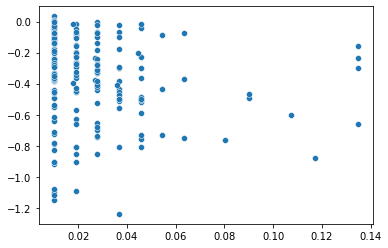

In [830]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[ high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins,:]['glu-gaba'].tolist())
#ax.set_ylim([0,1])

<AxesSubplot:>

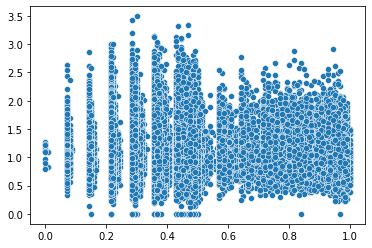

In [653]:
sns.scatterplot(y=df_group_max_intersection['glutamatergic'].tolist(), x=df_exp_tp_intersection['glutamatergic'].tolist())



<AxesSubplot:>

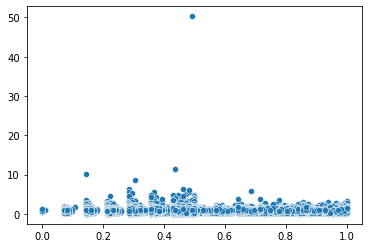

In [590]:
sns.scatterplot(y=df_group_max_intersection['gabaergic'].tolist(), x=df_exp_tp_intersection['gabaergic'].tolist())


(0.0, 5.0)

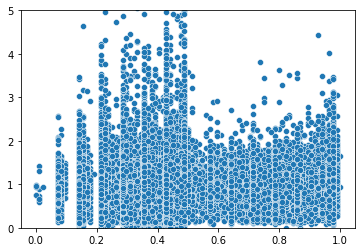

In [601]:
ax = sns.scatterplot(y=df_group_max_intersection['non-neuronal'].tolist(), x=df_exp_tp_intersection['non-neuronal'].tolist())
ax.set_ylim([0,5])

(0.0, 1.0)

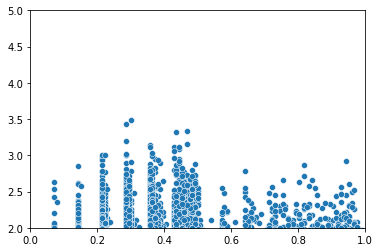

In [666]:
ax = sns.scatterplot(y=df_group_max_intersection['glutamatergic'].tolist(), x=df_exp_tp_intersection['glutamatergic'].tolist())
ax.set_ylim([2,5])
ax.set_xlim([0,1])


(0.0, 1.0)

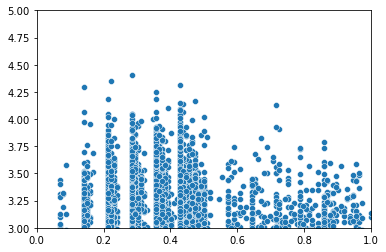

In [665]:
ax = sns.scatterplot(y=df_group_max_intersection['gabaergic'].tolist(), x=df_exp_tp_intersection['gabaergic'].tolist())
ax.set_ylim([3,5])
ax.set_xlim([0,1])


<AxesSubplot:ylabel='Count'>

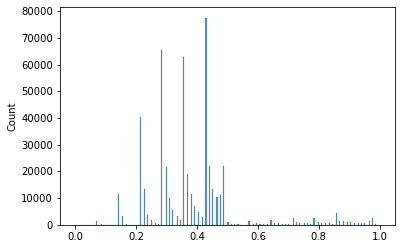

In [593]:
sns.histplot(df_exp_tp_intersection['non-neuronal'].tolist(),)

<AxesSubplot:ylabel='Count'>

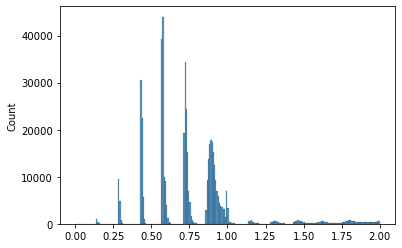

In [605]:
sns.histplot(df_exp_tp_intersection['glutamatergic'] + df_exp_tp_intersection['gabaergic'])

(0.0, 1.0)

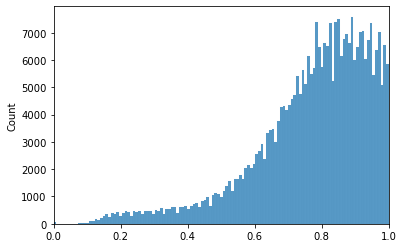

In [595]:
ax = sns.histplot(df_group_max_intersection['non-neuronal'].tolist(),)
ax.set_xlim([0,1])

In [ ]:
.loc[:, high_bins]

In [518]:
df_group_max_intersection.index.tolist()

group    glutamatergic  non-neuronal  gabaergic  glu-gaba
index                                                    
1048576          1.040         0.480      1.285    -0.245
1048578          0.520         0.280      0.835    -0.315
2097154          0.665         0.755      1.075    -0.410
1048582          0.875         0.405      1.115    -0.240
9                0.000         0.000      0.000     0.000
...                ...           ...        ...       ...
1048567          0.890         0.470      0.970    -0.080
2097146          0.800         0.895      1.380    -0.580
1048571          1.035         0.450      1.285    -0.250
2097149          0.620         0.595      0.890    -0.270
2097150          0.815         0.730      1.250    -0.435

[487825 rows x 4 columns]

(0.0, 1.0)

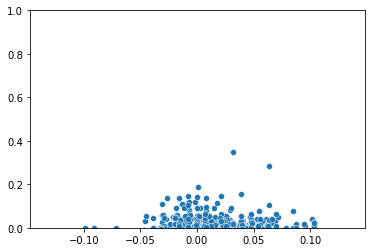

In [683]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[ high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins,:]['glu-gaba'].tolist())
#ax.set_ylim([0,1])


(-2.8275648951530457, 0.4993700385093689)

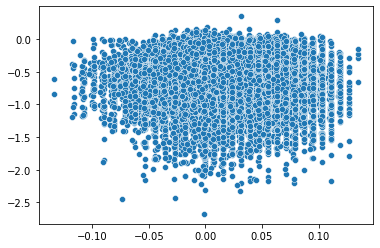

In [684]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[ high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins,:]['glu-gaba'].tolist())
ax.set_ylim()


(-2.0, -4.0)

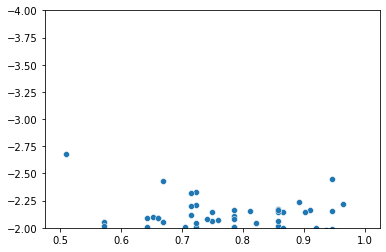

In [675]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[ high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins,:]['gabaergic'].tolist())
ax.set_ylim([-2,-4])


In [ ]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins, :]['glu-gaba'].tolist())
ax.set_ylim([-3,1])
ax.axhline(0)
ax.axvline(0)

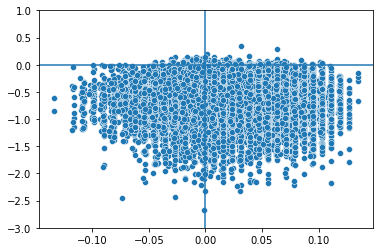

In [669]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins, :]['glu-gaba'].tolist())
ax.set_ylim([-3,1])
ax.axhline(0)
ax.axvline(0)


(1.0, 0.0)

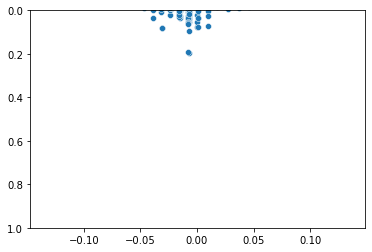

In [534]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection.loc[high_bins, :]['glu-gaba'].tolist())
ax.set_ylim([1,0])


In [526]:
df_group_max_intersection.loc[high_bins, :]

group    glutamatergic  non-neuronal  gabaergic  glu-gaba
index                                                    
1310721          0.470         0.345      0.810    -0.340
425987           0.800         0.640      1.270    -0.470
2031620          0.590         0.370      1.050    -0.460
491524           0.480         0.255      0.870    -0.390
2555911          0.720         0.650      1.010    -0.290
...                ...           ...        ...       ...
688120           0.670         0.635      0.920    -0.250
983033           0.485         0.280      0.755    -0.270
2260987          0.555         0.570      0.810    -0.255
2129916          0.700         0.610      1.205    -0.505
1146878          0.695         0.575      1.005    -0.310

[14036 rows x 4 columns]

In [512]:
df_exp_tp_intersection

group    glutamatergic  non-neuronal  gabaergic  glu-gaba
bin_id                                                   
1048576       0.285714      0.297619   0.285714  0.000000
1048578       0.658730      0.642857   0.660714 -0.001984
2097154       0.365079      0.392857   0.383929 -0.018849
1048582       0.293651      0.309524   0.294643 -0.000992
9             0.396825      0.404762   0.366071  0.030754
...                ...           ...        ...       ...
1048567       0.436508      0.428571   0.437500 -0.000992
2097146       0.285714      0.297619   0.285714  0.000000
1048571       0.365079      0.357143   0.357143  0.007937
2097149       0.285714      0.285714   0.285714  0.000000
2097150       0.476190      0.464286   0.464286  0.011905

[487825 rows x 4 columns]

In [667]:
df_group_max_intersection['glu-gaba'] = df_group_max_intersection['glutamatergic'] - df_group_max_intersection['gabaergic'] 

df_exp_tp_intersection['glu-gaba'] = df_exp_tp_intersection['glutamatergic'] - df_exp_tp_intersection['gabaergic'] 



In [ ]:
df_exp_tp_intersection_zcore = df_exp_tp_intersection.apply(stats.zscore)

In [701]:
df_exp_tp_intersection[['glutamatergic', 'non-neuronal','gabaergic']].T

bin_id          1048576   1048578   2097154   1048582   9         1048587  \
group                                                                       
glutamatergic  0.285714  0.658730  0.365079  0.293651  0.396825  0.976190   
non-neuronal   0.297619  0.642857  0.392857  0.309524  0.404762  0.857143   
gabaergic      0.285714  0.660714  0.383929  0.294643  0.366071  0.857143   

bin_id          2097166   1048591   2097167   1048593  ...   2097135  \
group                                                  ...             
glutamatergic  0.492063  0.380952  0.492063  0.476190  ...  0.285714   
non-neuronal   0.488095  0.357143  0.488095  0.428571  ...  0.285714   
gabaergic      0.500000  0.357143  0.500000  0.437500  ...  0.294643   

bin_id          2097138   2097139   1048564   2097141   1048567   2097146  \
group                                                                       
glutamatergic  0.365079  0.373016  0.912698  0.452381  0.436508  0.285714   
non-neuronal   0.369048  0.357143  0.857143  0.428571  0.428571  0.297619   
gabaergic      0.357143  0.357143  0.866071  0.491071  0.437500  0.285714   

bin_id          1048571   2097149   2097150  
group                                        
glutamatergic  0.365079  0.285714  0.476190  
non-neuronal   0.357143  0.285714  0.464286  
gabaergic      0.357143  0.285714  0.464286  

[3 rows x 487825 columns]

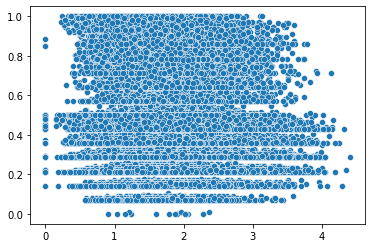

In [712]:
ax = sns.scatterplot(x=df_group_max_intersection['gabaergic'].tolist(), y=df_exp_tp_intersection['gabaergic'].tolist())
#ax.set_ylim([3,5])
#ax.set_xlim([0,1])

In [717]:
df_exp_tp_intersection_zscore

bin_id          1048576   1048578   2097154   1048582   9         1048587  \
group                                                                       
glutamatergic -0.707107  0.579324 -1.342309 -0.774329  0.455826  1.414214   
non-neuronal   1.414214 -1.406930  1.056712  1.412011  0.931470 -0.707107   
gabaergic     -0.707107  0.827606  0.285598 -0.637683 -1.387295 -0.707107   

bin_id          2097166   1048591   2097167   1048593  ...   2097135  \
group                                                  ...             
glutamatergic -0.267261  1.414214 -0.267261  1.392045  ... -0.707107   
non-neuronal  -1.069045 -0.707107 -1.069045 -0.912029  ... -0.707107   
gabaergic      1.336306 -0.707107  1.336306 -0.480015  ...  1.414214   

bin_id          2097138   2097139   1048564   2097141   1048567   2097146  \
group                                                                       
glutamatergic  0.267261  1.414214  1.398290 -0.192593  0.579324 -0.707107   
non-neuronal   1.069045 -0.707107 -0.882416 -1.117038 -1.406930  1.414214   
gabaergic     -1.336306 -0.707107 -0.515874  1.309631  0.827606 -0.707107   

bin_id          1048571  2097149   2097150  
group                                       
glutamatergic  1.414214      NaN  1.414214  
non-neuronal  -0.707107      NaN -0.707107  
gabaergic     -0.707107      NaN -0.707107  

[3 rows x 487825 columns]

In [803]:
high_bins =  list(set(df_exp_tp_intersection[ (df_exp_tp_intersection['glutamatergic']>=0.99)].index.tolist()))

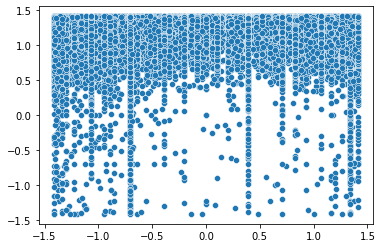

In [759]:
ax = sns.scatterplot(y=df_group_max_intersection_zscore.T['gabaergic'].tolist(), x=df_exp_tp_intersection_zscore.T['gabaergic'].tolist())



In [776]:
ax = sns.scatterplot(y=df_group_max_intersection['ga-glu'].loc[high_bins, :].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['glutamatergic'].tolist())


IndexingError: Too many indexers

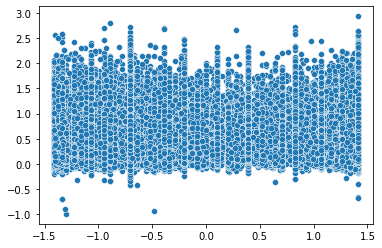

In [772]:
ax = sns.scatterplot(y=df_group_max_intersection['ga-glu'].tolist(), x=df_exp_tp_intersection_zscore.T['gabaergic'].tolist())


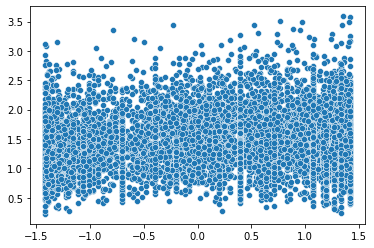

In [782]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['gabaergic'].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['gabaergic'].tolist())
#ax.set_ylim([3,5])
#ax.set_xlim([2,4])

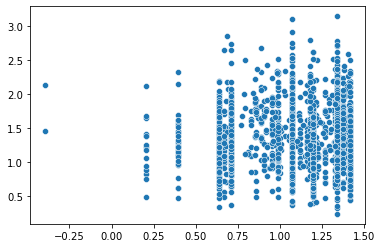

In [789]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['gabaergic'].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['gabaergic'].tolist())


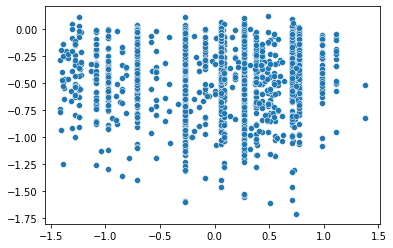

In [802]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['glu-gaba'].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['glutamatergic'].tolist())


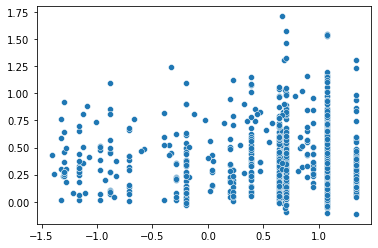

In [804]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['ga-glu'].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['gabaergic'].tolist())


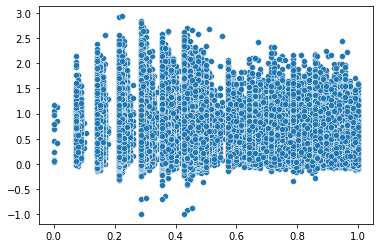

In [746]:
ax = sns.scatterplot(y=df_group_max_intersection['ga-glu'].tolist(), x=df_exp_tp_intersection['gabaergic'].tolist())


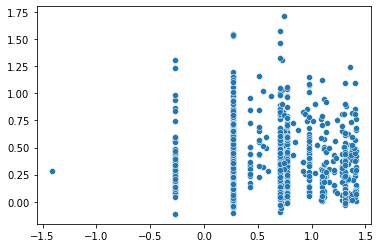

In [751]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['ga-glu'].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['glutamatergic'].tolist())
#ax.set_ylim([3,5])
#ax.set_xlim([2,4])


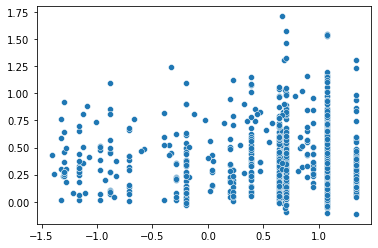

In [752]:
ax = sns.scatterplot(y=df_group_max_intersection.loc[high_bins, :]['ga-glu'].tolist(), x=df_exp_tp_intersection_zscore.T.loc[high_bins, :]['gabaergic'].tolist())
#ax.set_ylim([3,5])
#ax.set_xlim([2,4])


In [771]:
df_group_max_intersection['ga-glu'] =  df_group_max_intersection['gabaergic'] - df_group_max_intersection['glutamatergic']



In [787]:
df_group_max_intersection['glu-gaba'] =  df_group_max_intersection['glutamatergic'] - df_group_max_intersection['gabaergic'] 


In [767]:
df_exp_tp_intersection_zscore = df_exp_tp_intersection[['glutamatergic', 'non-neuronal','gabaergic']].T.apply(stats.zscore)



In [768]:
df_group_max_intersection_zscore = df_group_max_intersection[['glutamatergic', 'non-neuronal','gabaergic']].T.apply(stats.zscore)



In [755]:
df_group_max_intersection_zscore

index           1048576   1048578   2097154   1048582  9         1048587  \
group                                                                      
glutamatergic  0.311644 -0.110003 -0.947282  0.259991      NaN -0.099730   
non-neuronal  -1.350460 -1.166033 -0.435750 -1.333866      NaN -1.171831   
gabaergic      1.038815  1.276036  1.383033  1.073875      NaN  1.271561   

index           2097166   1048591   2097167   1048593  ...   2097135  \
group                                                  ...             
glutamatergic -0.485665  0.285598 -0.609699  0.327900  ... -0.602595   
non-neuronal  -0.907427 -1.342309 -0.800230 -1.355319  ... -0.806700   
gabaergic      1.393092  1.056712  1.409929  1.027420  ...  1.409296   

index           2097138   2097139   1048564   2097141   1048567   2097146  \
group                                                                       
glutamatergic -0.387125 -0.417286  0.515874 -0.776981  0.516815 -0.885822   
non-neuronal  -0.984402 -0.961572 -1.398290 -0.634850 -1.398441 -0.511808   
gabaergic      1.371527  1.378859  0.882416  1.411831  0.881626  1.397631   

index           1048571   2097149   2097150  
group                                        
glutamatergic  0.319127 -0.611450 -0.512247  
non-neuronal  -1.352719 -0.798629 -0.885455  
gabaergic      1.033591  1.410079  1.397702  

[3 rows x 487825 columns]

In [706]:
df_exp_tp_intersection_zscore.T

group    glutamatergic  non-neuronal  gabaergic
bin_id                                         
1048576      -0.707107      1.414214  -0.707107
1048578       0.579324     -1.406930   0.827606
2097154      -1.342309      1.056712   0.285598
1048582      -0.774329      1.412011  -0.637683
9             0.455826      0.931470  -1.387295
...                ...           ...        ...
1048567       0.579324     -1.406930   0.827606
2097146      -0.707107      1.414214  -0.707107
1048571       1.414214     -0.707107  -0.707107
2097149            NaN           NaN        NaN
2097150       1.414214     -0.707107  -0.707107

[487825 rows x 3 columns]

In [410]:
 df_exp_tp_intersection[ df_exp_tp_intersection['glutamatergic']>=0.99]

group    glutamatergic  non-neuronal  gabaergic
bin_id                                         
2097543       0.992063      0.976190   0.955357
2097821       0.992063      0.976190   1.000000
2098651       1.000000      0.976190   0.991071
3900          0.992063      0.976190   1.000000
2106476       0.992063      0.940476   1.000000
...                ...           ...        ...
1030914       0.992063      0.988095   1.000000
1031433       0.992063      0.976190   1.000000
1037393       1.000000      0.976190   1.000000
1039781       0.992063      0.976190   0.991071
1043099       0.992063      0.976190   0.991071

[965 rows x 3 columns]

In [612]:
high_bins =  list(set(df_exp_tp_intersection[ (df_exp_tp_intersection['gabaergic']>=0.5)].index.tolist() + df_exp_tp_intersection[ (df_exp_tp_intersection['glutamatergic']>=0.5)].index.tolist()))
                          

In [694]:
len(df_exp_tp_intersection[ (df_exp_tp_intersection['gabaergic']>0.99)].index.tolist() )

2107

In [695]:
len(df_exp_tp_intersection[ (df_exp_tp_intersection['glutamatergic']>0.99)].index.tolist() )

965

In [399]:
 df_exp_tp_intersection[ df_exp_tp_intersection['non-neuronal']>=0.99]

group    glutamatergic  non-neuronal  gabaergic
bin_id                                         
1344457       0.992063           1.0        1.0
1734793       0.984127           1.0        1.0

In [529]:
len(high_bins )

2300

In [413]:
marker_level='type'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())


<AxesSubplot:>

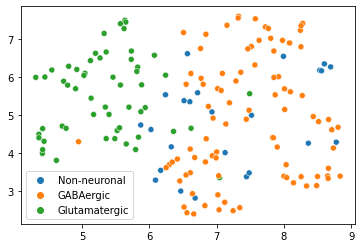

In [562]:
from umap import UMAP
import plotly.express as px

df = df_max_gene_inter_by_bins_normalized.dropna(axis=1)


#features = df
features = df




umap_2d = UMAP(n_components=2, init='random', random_state=0)




proj_2d = umap_2d.fit_transform(features)


%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=class_list)

In [381]:
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection['gabaergic'].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))

glutamatergic
0.6173208250412578
non-neuronal
0.6455586973398814
gabaergic
0.5499396615909795


In [386]:
df_group_max_intersection.T.iloc([['glutamatergic', 'gabaergic'], :])

SyntaxError: invalid syntax (<ipython-input-386-693904b4c71d>, line 1)

In [388]:
df_group_max_intersection[['glutamatergic', 'gabaergic']]

group    glutamatergic  gabaergic
index                            
1048576          1.040      1.285
1048578          0.520      0.835
2097154          0.665      1.075
1048582          0.875      1.115
9                0.000      0.000
...                ...        ...
1048567          0.890      0.970
2097146          0.800      1.380
1048571          1.035      1.285
2097149          0.620      0.890
2097150          0.815      1.250

[487825 rows x 2 columns]

In [369]:
marker_level='type'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())



In [370]:
df_max_gene_inter_by_bins_tmp

0        1        2        3        4        5        6        \
Astro_1      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Astro_2      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Astro_3      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Astro_4      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Astro_5      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...          ...      ...      ...      ...      ...      ...      ...   
Vip_7        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip_8        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip_9        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
VLMC_1       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
VLMC_2       0.0      0.0      0.0      0.0      0.0      0.0      0.0   

         7        8        9        ...  2875002  2875003  2875004  2875005  \
Astro_1      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
Astro_2      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
Astro_3      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
Astro_4      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
Astro_5      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
...          ...      ...      ...  ...      ...      ...      ...      ...   
Vip_7        0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
Vip_8        0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
Vip_9        0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
VLMC_1       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
VLMC_2       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

         2875006  2875007  2875008  2875009  2875010  2875011  
Astro_1      0.0      0.0      0.0      0.0      0.0      0.0  
Astro_2      0.0      0.0      0.0      0.0      0.0      0.0  
Astro_3      0.0      0.0      0.0      0.0      0.0      0.0  
Astro_4      0.0      0.0      0.0      0.0      0.0      0.0  
Astro_5      0.0      0.0      0.0      0.0      0.0      0.0  
...          ...      ...      ...      ...      ...      ...  
Vip_7        0.0      0.0      0.0      0.0      0.0      0.0  
Vip_8        0.0      0.0      0.0      0.0      0.0      0.0  
Vip_9        0.0      0.0      0.0      0.0      0.0      0.0  
VLMC_1       0.0      0.0      0.0      0.0      0.0      0.0  
VLMC_2       0.0      0.0      0.0      0.0      0.0      0.0  

[170 rows x 2875012 columns]

In [363]:
    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin[0:100000]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
                print (np.nanmean(np.array(val_list3)))

0.5
0.25
0.5
0.375
0.3
0.3333333333333333
0.35714285714285715
0.3125
0.3888888888888889
0.35
0.4090909090909091
0.4583333333333333
0.46153846153846156
0.4642857142857143
0.4666666666666667
0.5
0.5294117647058824
0.5555555555555556
0.5526315789473685
0.575
0.5952380952380952
0.6136363636363636
0.6304347826086957
0.6458333333333334
0.66
0.6538461538461539
0.6481481481481481
0.6428571428571429
0.6551724137931034
0.6666666666666666
0.6774193548387096
0.671875
0.6818181818181818
0.6764705882352942
0.6714285714285714
0.6805555555555556
0.6621621621621622
0.6447368421052632
0.6410256410256411
0.65
0.6463414634146342
0.6547619047619048
0.6627906976744186
0.6590909090909091
0.6666666666666666
0.6739130434782609
0.6702127659574468
0.6770833333333334
0.6632653061224489
0.67
0.6764705882352942
0.6826923076923077
0.6886792452830188
0.6944444444444444
0.6909090909090909
0.6964285714285714
0.6929824561403509
0.6896551724137931
0.6779661016949152
0.6833333333333333
0.6885245901639344
0.677419354838709

KeyboardInterrupt: 

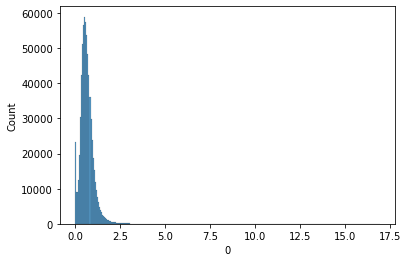

In [225]:
ax=sns.histplot(df_max_gene_inter_by_bins_sum_mean[df_max_gene_inter_by_bins_sum_mean.index.isin(cre_bins)][0], bins=300)
#ax.set_xlim([0,5])


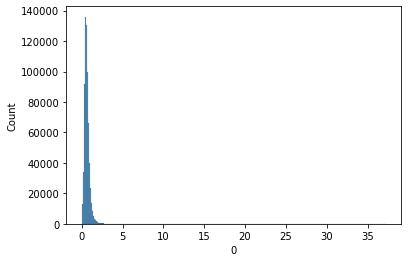

In [233]:
ax=sns.histplot(df_max_gene_inter_by_bins_sum_mean[df_max_gene_inter_by_bins_sum_mean.index.isin(cre_bins)][0], bins=300)
#ax.set_xlim([0,5])

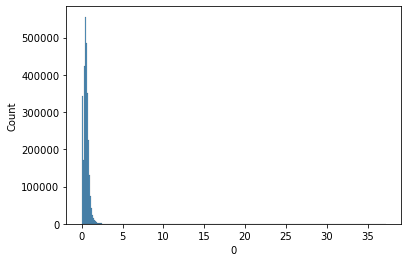

In [226]:
ax=sns.histplot(df_max_gene_inter_by_bins_sum_mean[0], bins=300)
#ax.set_xlim([0,5])

In [228]:
df_max_gene_inter_by_bins_sum_mean[0].median()

0.4839974343776703

In [20]:
from umap import UMAP
import plotly.express as px
import seaborn as sns


fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=subclass_list, labels={'color': 'group'}, color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta", "tomato", "black", "lime", "cyan", "teal", "aqua", "lime", "chocolate", "violet", "black", "lightcoral", "yellowgreen", "orchid", "grey"]
)


fig_2d.show()

In [ ]:


with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gw.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())



In [ ]:
df_concat_list_mean_nn_by_bins_normalized_1 = df_max_gene_inter_by_bins_tmp.div(df_max_gene_gw_by_bins_sum['0']/2875012, axis=1)
df_concat_list_mean_nn_by_bins_normalized = 1 - df_concat_list_mean_nn_by_bins_normalized_1


In [ ]:
from umap import UMAP
import plotly.express as px

df = df_concat_list_mean_nn_by_bins_normalized.dropna(axis=1)


features = df
#features = df.loc[:, nongene_bins_all_present]




umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [25]:
cell_type_map = {'ITL23' : 'L2/3 IT' ,
'ITL4' : 'L4 IT' ,
'ITL5' : 'L5 IT' ,
'ITL6_1' : 'L6 IT' ,
'ITL6_2' : 'L6 IT CAR3' ,
'CT' : 'L6 CT' ,
'L6B' : 'L6B' ,
'NP' : 'L5/6 NP' ,
'ET' : 'L5 ET' ,
'SST_CHODL' : 'SST CHODL' ,
'SST' : 'SST' ,
'PVALB' : 'PVALB' ,
'PV_ChCs' : 'CHANDELIER' ,
'VIP' : 'VIP' ,
'SNCG' : 'SNCG' ,
'LAMP5' : 'LAMP5' ,
'LAMP5_LHX6' : 'LAMP5_LHX6' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'MICRO-PVM' ,
'OPC' : 'OPC' ,
'OGC' : 'OLIGO' ,
'EC' : 'ENDO' ,
'Glutamatergic' : 'Glutamatergic',
'GABAergic' : 'GABAergic',
'Non-neuronal' : 'Non-neuronal'          
}



class_map = {'ITL23' : 'Glutamatergic' ,
'ITL4' : 'Glutamatergic' ,
'ITL5' : 'Glutamatergic' ,
'ITL6_1' : 'Glutamatergic' ,
'ITL6_2' : 'Glutamatergic' ,
'CT' : 'Glutamatergic' ,
'L6B' : 'Glutamatergic' ,
'NP' : 'Glutamatergic' ,
'ET' : 'Glutamatergic' ,
'SST_CHODL' : 'GABAergic' ,
'SST' : 'GABAergic' ,
'PVALB' : 'GABAergic' ,
'PV_ChCs' : 'GABAergic' ,
'VIP' : 'GABAergic' ,
'SNCG' : 'GABAergic' ,
'LAMP5' : 'GABAergic' ,
'LAMP5_LHX6' : 'GABAergic' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'Non-neuronal' ,
'OPC' : 'Non-neuronal' ,
'OGC' : 'Non-neuronal' ,
'EC' : 'Non-neuronal' , }

class_types = ['Glutamatergic', 'GABAergic', 'Non-neuronal']

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['start']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
#df_cre_1kb = df_cre.drop_duplicates(subset=['start_bin'])

df_cre_1kb = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

df_exp_list = []

for key in cell_type_map:

    df_exp = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/{key}.txt', names=['cCRE_name'])

    df_exp = df_exp.merge(df_cre_1kb)[['bin_id']]

    df_exp['tp'] = 1
    
    df_exp = df_exp.groupby(['bin_id'])['tp'].sum().reset_index()

    df_exp['tp'] = df_exp['tp']/df_exp['tp'].max()
    
    #df_exp = df_exp.drop_duplicates(subset=['bin_id'])

    df_exp = df_exp.set_index('bin_id').T
    
    df_exp['group'] = cell_type_map[key].lower()
    
    df_exp_list.append(df_exp)


df_exp_tp = pd.concat(df_exp_list)

df_exp_tp = df_exp_tp.fillna(0)


In [200]:
var_index = df_max_gene_inter_by_bins_std[df_max_gene_inter_by_bins_std[0] > 0].index.tolist()

In [174]:
df_tp_sum = df_exp_tp.loc[:,df_exp_tp.columns !='group'].sum().reset_index()

In [201]:
var_index_exp = df_tp_sum[df_tp_sum[0] < 9].bin_id.tolist()

In [202]:
all_var_index = list(set(var_index_exp).intersection(set(var_index)))

In [209]:
marker_level='subclass'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())
#df_concat_list_mean_nn_by_bins_normalized_tmp = [np.nan if ]
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_sum_mean[0]

#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(((df_max_gene_inter_by_bins_sum_mean[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.dropna(axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.mul(((df_max_gene_inter_by_bins_sum_mean[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(((1-df_max_gene_inter_by_bins_sum[0])), axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_max_gene_inter_by_bins_tmp - df_max_gene_inter_by_bins_sum_mean[0]).div(df_max_gene_inter_by_bins_std[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_concat_list_mean_nn_by_bins_normalized_tmp).div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)
#df_concat_list_mean_nn_by_bins_normalized_tmp = (df_max_gene_inter_by_bins_tmp*0)+df_max_gene_inter_by_bins_std[0]
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_max_gene_inter_by_bins_tmp.div(df_concat_list_mean_nn_by_bins_normalized_max, axis=1)

#df_concat_list_mean_nn_by_bins_normalized_tmp =  ( (df_max_gene_gw_by_bins_sum['0']/2875012)+1-df_concat_list_mean_nn_by_bins_normalized_tmp)
#df_concat_list_mean_nn_by_bins_normalized_tmp =   1-df_concat_list_mean_nn_by_bins_normalized_tmp
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp.abs()
#df_concat_list_mean_nn_by_bins_normalized_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp * df_max_gene_inter_by_bins_sum_mean[0]
#df_max_gene_inter_by_bins_tmp = df_concat_list_mean_nn_by_bins_normalized_tmp
#df_max_gene_inter_by_bins_tmp = df_max_gene_inter_by_bins_tmp.loc[:,var_index ]


df_max_gene_inter_by_bins_tmp['group'] = [x.decode() for x in type_list.tolist()]



if marker_level != 'type':

    df_group_max = df_max_gene_inter_by_bins_tmp

    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list4 = []
    tp_list4 = []
    for group_t in intersection_bin[:100]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list4.append(calc_auroc(df, 'enrich'))
                tp_list4.append(df['true_pos'].tolist())

                #print (calc_auroc(df, 'enrich'))
                print (marker_level, np.nanmean(np.array(val_list4)))
    print (marker_level, np.nanmean(np.array(val_list4)))
    
    df_exp_tp_intersection_min = df_exp_tp_intersection.min(axis=1).reset_index()[0].tolist()
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        #j = [x-base for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]
        #df['true_pos'] = [1 if (x-base)>0 else 0 for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]
        #df['true_pos'] = [1 if (0.2<x<0.4) else 0 for x in df['true_pos'] ]
        max_value = np.percentile(df['true_pos'].tolist(), 90)
        print (max_value)
        
        df_z = abs(stats.zscore(df['true_pos'].tolist()))
        max_value =np.percentile(df_z, 90)
        df['true_pos'] = [1 if x<=max_value else 0 for x in df_z ]
        
        #print ([x-base for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ])
        #print (max([x-base for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]))
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
                

if marker_level == 'subclass':
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    print (class_dict)
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/class_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].mean().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            #max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())

                #print (calc_auroc(df, 'enrich'))
                print (marker_level, "subclass", np.nanmean(np.array(val_list3)))
    print (marker_level, "subclass", np.nanmean(np.array(val_list3)))
    
    df_exp_tp_intersection_min = df_exp_tp_intersection.min(axis=1).reset_index()[0].tolist()
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        
        #df['true_pos'] = [1 if (x-base)>0 else 0 for x, base in zip(df['true_pos'], df_exp_tp_intersection_min) ]
        #df['true_pos'] = [1 if (x>=0.99) else 0 for x in df['true_pos'] ]
        
        df_z = abs(stats.zscore(df['true_pos'].tolist()))
        max_value =np.percentile(df_z, 10)
        df['true_pos'] = [1 if x<=max_value else 0 for x in df_z ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
    

if marker_level == 'type':
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    print (class_dict)
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin[:1000]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
    print (marker_level, "subclass", np.nanmean(np.array(val_list3)))
    
    val_list_subclass = []
    group_subclass = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        group_subclass.append(group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection[group_t].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df['true_pos'] = [1 if x>0 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list_subclass.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
                
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x] for x in df_max_gene_inter_by_bins_tmp['subclass'].tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/class_markers_top1000.csv.gz', skiprows=1)

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    
    group_max = []
    for groupname in class_dict:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["subclass"] == groupname].loc[:, :2875011].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    cre_columns = df_exp_tp.columns.tolist()

    enrichment_bins = df_group_max.columns.tolist()

    intersection_bin = list(set(cre_columns).intersection(set(enrichment_bins)))

    df_exp_tp_intersection = df_exp_tp[intersection_bin]

    df_group_max_intersection = df_group_max[intersection_bin]

    #cell_type_map = ['GABAergic', 'Glutamatergic', 'Non-neuronal']
    df_group_max_intersection['group'] = df_group_max_intersection['group'].str.lower()

    group_list = list(set(df_group_max_intersection['group'].tolist()).intersection(set(df_exp_tp_intersection['group'].tolist())))

    df_group_max_intersection = df_group_max_intersection.set_index('group').T[group_list]

    df_exp_tp_intersection = df_exp_tp_intersection.set_index('group').T[group_list]

    val_list3 = []
    tp_list3 = []
    for group_t in intersection_bin[:10000]:
        if group_t != 'group':

            df = pd.DataFrame(list(zip(df_group_max_intersection.T[group_t].tolist(), df_exp_tp_intersection.T[group_t].tolist())),
                           columns =['enrich', 'true_pos'])
            #print (df)
            #df['class'] = ['Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gluta', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'Gaba', 'NN', 'NN', 'NN', 'NN', 'NN']
            #df['class'] = ['l2/3 it','l4 it','l5 it','l6 it','l6 it car3','l6 ct','l6b','l5/6 np','l5 et','sst chodl','sst','pvalb','chandelier','vip','sncg','lamp5','lamp5_lhx6','astro','micro-pvm','opc','oligo','endo']
            #df = df[df['class'].isin(['sncg', 'lamp5'])]
            #df = df.groupby(['class'])['true_pos', 'enrich'].min().reset_index()
            #df['true_pos'] = np.random.permutation(df['true_pos'].values)
            #print (df['true_pos'].max())
            #df = df[df['class'] !='NN']
            #print (df)
            max_value = np.percentile(df['true_pos'].tolist(), 99)
            #df['true_pos'] = [1 if x>=max_value else 0 for x in df['true_pos'] ]
            df['true_pos'] = [1 if x>=0.99 else 0 for x in df['true_pos'] ]
            df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
            #print (df)
            if df['true_pos'].sum()  >= 1:
                val_list3.append(calc_auroc(df, 'enrich'))
                tp_list3.append(df['true_pos'].tolist())
                
                print (np.nanmean(np.array(val_list3)))
                
    print (marker_level, "class", np.nanmean(np.array(val_list3)))
    
    val_list = []
    #for group_t in cell_type_map :
    #for group_t in intersection_bin :
    for group_t in group_list :
        print (group_t)
        df = pd.DataFrame(list(zip(df_group_max_intersection[group_t].tolist(), df_exp_tp_intersection['gabaergic'].tolist())),
                       columns =['enrich', 'true_pos'])
        df.dropna(inplace=True)
        df['true_pos'] = [1 if x>0 else 0 for x in df['true_pos'] ]
        df['true_neg'] = [1 if x==0 else 0 for x in df['true_pos'] ]
        val_list.append(calc_auroc(df, 'enrich'))
        print (calc_auroc(df, 'enrich'))
    


<ipython-input-209-321eeeac6bf7>:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



subclass 0.09523809523809523
subclass 0.4156746031746032
subclass 0.42949735449735454
subclass 0.4505952380952381
subclass 0.46047619047619043
subclass 0.482688492063492
subclass 0.5351615646258503
subclass 0.5252839129072682
subclass 0.5502523670286829
subclass 0.5599890350877192
subclass 0.5590809409888357
subclass 0.5526869410044719
subclass 0.5437031329193153
subclass 0.5415735440599991
subclass 0.55225226685366
subclass 0.552295323704718
subclass 0.5568346744111632
subclass 0.5444179332401727
subclass 0.5488470645733967
subclass 0.5488470645733967
subclass 0.5488470645733967
subclass 0.5488470645733967
subclass 0.547595187535203
subclass 0.5413604960652727
subclass 0.5370995211358989
subclass 0.5503606403542465
subclass 0.5581002433024492
subclass 0.5581002433024492
subclass 0.5491095669036846
subclass 0.5491095669036846
subclass 0.5502571746543526
subclass 0.559942638773908
subclass 0.5581151134542885
subclass 0.5492145923006924
subclass 0.5489466549102773
subclass 0.549075510444

<ipython-input-209-321eeeac6bf7>:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



subclass subclass 0.5
subclass subclass 0.75
subclass subclass 0.8333333333333334
subclass subclass 0.875
subclass subclass 0.9
subclass subclass 0.9166666666666666
subclass subclass 0.9285714285714286
subclass subclass 0.9375
subclass subclass 0.9444444444444444
subclass subclass 0.9
subclass subclass 0.9090909090909091
subclass subclass 0.9166666666666666
subclass subclass 0.9230769230769231
subclass subclass 0.9285714285714286
subclass subclass 0.9
subclass subclass 0.90625
subclass subclass 0.9117647058823529
subclass subclass 0.9166666666666666
subclass subclass 0.9210526315789473
subclass subclass 0.925
subclass subclass 0.9285714285714286
subclass subclass 0.9318181818181818
subclass subclass 0.9347826086956522
subclass subclass 0.9375


KeyboardInterrupt: 

In [189]:
df_z.mean()

0.7103129384576976

In [197]:
np.percentile(df_z, 10)

0.16710245981543462

In [192]:
df_z.min()

0.16710245981543462

In [181]:
df_group_max_intersection

group       l4 it     astro     l5 it       opc     oligo       vip  \
1048576  1.317204  1.143617  1.376963  1.577540  0.984211  1.005291   
1048578  0.811828  0.654255  0.958115  1.000000  0.710526  0.693122   
2097154  1.177665  1.107692  1.209184  1.226804  1.025510  0.954082   
1048582  1.198925  0.904255  1.293194  1.368984  0.878947  0.941799   
1048587  0.919355  0.792553  1.036649  1.037433  0.794737  0.656085   
...           ...       ...       ...       ...       ...       ...   
1048567  1.053763  0.867021  1.178010  1.219251  0.863158  0.830688   
2097146  1.345178  1.169231  1.520408  1.561856  1.270408  1.193878   
1048571  1.258065  1.026596  1.476440  1.529412  1.042105  1.037037   
2097149  1.005076  0.928205  1.045918  1.041237  0.959184  0.816327   
2097150  1.243655  1.200000  1.352041  1.432990  1.086735  1.112245   

group    l6 it car3  sst chodl      endo     l5 et  ...  lamp5_lhx6     pvalb  \
1048576    0.973118   1.265957  0.994764  1.216216  ...    1.329843  1.378378   
1048578    0.704301   0.829787  0.701571  0.859459  ...    0.916230  0.870270   
2097154    0.948187   1.098446  0.974227  1.109948  ...    1.156250  1.063158   
1048582    0.795699   1.244681  0.931937  1.005405  ...    1.235602  1.140541   
1048587    0.715054   0.909574  0.722513  0.848649  ...    0.937173  0.918919   
...             ...        ...       ...       ...  ...         ...       ...   
1048567    0.758065   0.973404  0.884817  0.989189  ...    1.052356  1.118919   
2097146    1.170985   1.274611  1.139175  1.282722  ...    1.427083  1.336842   
1048571    0.978495   1.239362  1.052356  1.329730  ...    1.335078  1.383784   
2097149    0.725389   0.943005  0.871134  0.958115  ...    1.067708  0.889474   
2097150    1.036269   1.186528  1.118557  1.172775  ...    1.302083  1.257895   

group         sst     lamp5  micro-pvm     l6 ct  chandelier   l5/6 np  \
1048576  1.427027  1.293478   0.994681  1.250000    1.353261  1.191257   
1048578  0.875676  0.956522   0.702128  0.796875    0.815217  0.721311   
2097154  1.170985  1.072539   1.015464  1.103093    1.171875  0.994819   
1048582  1.194595  1.173913   0.914894  1.270833    1.097826  0.978142   
1048587  0.956757  0.951087   0.734043  0.906250    0.815217  0.759563   
...           ...       ...        ...       ...         ...       ...   
1048567  1.064865  1.086957   0.925532  1.031250    1.038043  0.885246   
2097146  1.507772  1.450777   1.350515  1.422680    1.359375  1.248705   
1048571  1.297297  1.282609   1.069149  1.192708    1.206522  1.032787   
2097149  1.036269  0.932642   0.932990  0.974227    0.989583  0.922280   
2097150  1.321244  1.238342   1.216495  1.268041    1.270833  1.139896   

group     l2/3 it       l6b  
1048576  1.535912  1.153439  
1048578  0.922652  0.746032  
2097154  1.153846  0.964467  
1048582  1.204420  1.000000  
1048587  0.895028  0.830688  
...           ...       ...  
1048567  1.060773  0.915344  
2097146  1.420513  1.243655  
1048571  1.298343  1.132275  
2097149  0.969231  0.923858  
2097150  1.369231  1.106599  

[487819 rows x 22 columns]

In [100]:
df_max_gene_inter_by_bins_tmp.dropna(axis=1)

10        11        12        13        14        15        16  \
Astro_1  1.809014  3.450735  1.251467  1.730822  1.374604  1.332550  1.341146   
Astro_2  2.365634  5.751225  3.754400  2.307763  2.265551  1.650545  2.150895   
Astro_3  2.035141  2.300490  1.251467  1.710217  1.730983  1.544547  1.518279   
Astro_4  2.139507  1.150245  1.564333  2.039897  2.240095  1.847399  2.037024   
Astro_5  1.948169  1.150245  1.564333  1.998687  1.883717  1.620260  2.024372   
...           ...       ...       ...       ...       ...       ...       ...   
Vip_7    2.852676  1.150245  1.877200  2.348973  2.291007  1.938255  2.188852   
Vip_8    2.261268  3.450735  3.128667  1.957477  2.010995  1.605117  1.821935   
Vip_9    2.835282  5.751225  4.693000  2.060502  2.265551  1.953398  2.087633   
VLMC_1   2.783099  4.600980  2.190067  2.225343  2.163728  2.029111  2.252114   
VLMC_2   1.895986  1.150245  2.190067  1.669007  1.680072  2.195680  2.441899   

               17        18        19  ...   2874994   2874995   2874996  \
Astro_1  1.650443  0.000000  1.399357  ...  1.384517  1.415070  2.550543   
Astro_2  2.870336  1.268378  2.062210  ...  2.102415  2.547126  1.275272   
Astro_3  1.865718  1.268378  1.620308  ...  1.504167  1.729530  2.550543   
Astro_4  2.296269  0.634189  2.135860  ...  1.863116  2.358449  3.825815   
Astro_5  1.650443  0.000000  1.841259  ...  1.880208  1.886760  5.101087   
...           ...       ...       ...  ...       ...       ...       ...   
Vip_7    2.655061  2.536757  3.166965  ...  1.982765  1.886760  1.275272   
Vip_8    2.152752  0.634189  2.209511  ...  2.153693  1.760976  1.275272   
Vip_9    2.368027  1.268378  2.725063  ...  2.375900  2.012544  1.275272   
VLMC_1   2.439786  0.634189  2.798713  ...  2.273343  2.421341  5.101087   
VLMC_2   2.152752  0.634189  1.693958  ...  1.760559  1.886760  1.275272   

          2874997   2874998   2874999   2875000   2875001    group  \
Astro_1  1.614886  1.878968  4.888541  1.673283  1.966951  Astro_1   
Astro_2  2.703179  2.321079  0.000000  2.677252  2.404052  Astro_2   
Astro_3  1.965949  1.878968  0.000000  2.063715  2.404052  Astro_3   
Astro_4  2.632967  2.652661  4.888541  2.314708  2.914002  Astro_4   
Astro_5  2.527648  2.376342  1.629514  2.007939  2.549752  Astro_5   
...           ...       ...       ...       ...       ...      ...   
Vip_7    2.457436  3.039508  4.888541  2.593588  2.841152    Vip_7   
Vip_8    2.281904  2.265815  4.888541  2.454148  2.622602    Vip_8   
Vip_9    2.562755  2.431606  4.888541  2.984021  2.841152    Vip_9   
VLMC_1   2.632967  2.984244  6.518055  2.565700  3.496802   VLMC_1   
VLMC_2   2.071267  1.768441  1.629514  1.756947  2.549752   VLMC_2   

             subclass  
Astro_1  Non-neuronal  
Astro_2  Non-neuronal  
Astro_3  Non-neuronal  
Astro_4  Non-neuronal  
Astro_5  Non-neuronal  
...               ...  
Vip_7       GABAergic  
Vip_8       GABAergic  
Vip_9       GABAergic  
VLMC_1   Non-neuronal  
VLMC_2   Non-neuronal  

[170 rows x 2736350 columns]

In [94]:
df.dropna()

enrich  true_pos  true_neg
0        1.285         0         1
1        0.835         0         1
2        1.075         0         1
3        1.115         0         1
4        0.000         0         1
...        ...       ...       ...
487820   0.970         0         1
487821   1.380         0         1
487822   1.285         0         1
487823   0.890         0         1
487824   1.250         0         1

[487825 rows x 3 columns]

In [76]:
df_group_max_intersection

group    glutamatergic  non-neuronal  gabaergic
1048576      11.783919         1.145   1.507538
1048578       5.422111         0.745   0.889447
2097154       0.914573         1.105   1.010050
1048582      11.678392         0.950   1.256281
9             0.000000         0.000   0.000000
...                ...           ...        ...
1048567      15.537688         1.000   1.035176
2097146       1.150754         1.310   1.231156
1048571      14.748744         1.150   1.407035
2097149       0.809045         1.005   0.944724
2097150       1.110553         1.315   1.150754

[487825 rows x 3 columns]

In [124]:
df_exp_tp.sum()

bin_id
9           9.739087
180        11.857143
191        11.781746
267         7.472222
585         5.686508
             ...    
1839214     0.083333
1893812     0.083333
1909374     0.083333
1941964     0.083333
1948064     0.083333
Length: 487826, dtype: object

In [123]:
df_exp_tp

bin_id   9         180       191       267       585       629      633      \
tp      0.428571  0.500000  0.428571  0.285714  0.214286  0.500000      0.5   
tp      0.428571  0.500000  0.428571  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.500000  0.428571  0.285714  0.214286  0.500000      0.5   
tp      0.428571  0.500000  0.428571  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.428571  0.428571  0.285714  0.214286  0.428571      0.5   
tp      0.428571  0.500000  0.500000  0.357143  0.285714  0.500000      0.5   
tp      0.428571  0.500000  0.428571  0.285714  0.214286  0.428571      0.5   
tp      0.357143  0.428571  0.428571  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.428571  0.428571  0.285714  0.214286  0.428571      0.5   
tp      0.357143  0.428571  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.500000  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.500000  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.428571  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.428571  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.428571  0.428571  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.500000  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.357143  0.500000  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.428571  0.500000  0.500000  0.357143  0.285714  0.500000      0.5   
tp      0.428571  0.500000  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.428571  0.500000  0.500000  0.357143  0.285714  0.500000      0.5   
tp      0.428571  0.500000  0.500000  0.357143  0.285714  0.500000      0.5   
tp      0.357143  0.428571  0.428571  0.285714  0.214286  0.428571      0.5   
tp      0.396825  0.476190  0.436508  0.293651  0.222222  0.476190      0.5   
tp      0.366071  0.464286  0.500000  0.285714  0.214286  0.500000      0.5   
tp      0.404762  0.488095  0.488095  0.321429  0.250000  0.488095      0.5   

bin_id   778       779       817      ...   5535      46026     1804305  \
tp      1.000000  0.428571  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.428571  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.428571  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.357143  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.428571  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      0.857143  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      0.928571  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      0.928571  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.357143  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.357143  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.357143  ...  0.000000  0.000000  0.000000   
tp      1.000000  0.357143  0.357143  ...  0.071429  0.071429  0.071429   
tp      1.000000  0.357143  0.357143  ...  0.000000  0.000000  0.000000   
tp      0.857143  0.357143  0.285714  ...  0.000000  0.000000  0.000000   
tp      0.984127  0.388889  0.293651  ...  0.000000  0.000000  0.000000   
tp      0.982143  0.357143  0.294643  ...  0.000000  0.000000  0.000000   
tp      0.976190  0.357143  0.345238  ...  0.011905  0.011905  0.01190

In [78]:
df

enrich  true_pos  true_neg
0       1.507538         0         1
1       0.889447         0         1
2       1.010050         0         1
3       1.256281         0         1
4       0.000000         0         1
...          ...       ...       ...
487820  1.035176         0         1
487821  1.231156         0         1
487822  1.407035         0         1
487823  0.944724         0         1
487824  1.150754         0         1

[487825 rows x 3 columns]

<AxesSubplot:xlabel='enrich', ylabel='true_pos'>

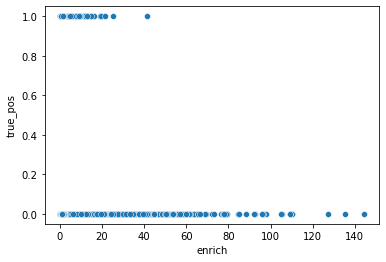

In [79]:
sns.scatterplot(x=df['enrich'], y=df['true_pos'])

In [80]:
df_orig = df


In [81]:
df_orig

enrich  true_pos  true_neg
0       1.507538         0         1
1       0.889447         0         1
2       1.010050         0         1
3       1.256281         0         1
4       0.000000         0         1
...          ...       ...       ...
487820  1.035176         0         1
487821  1.231156         0         1
487822  1.407035         0         1
487823  0.944724         0         1
487824  1.150754         0         1

[487825 rows x 3 columns]